In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble # RandomForestClassifier()
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn import neighbors

from statsmodels.tools.eval_measures import mse, rmse
from math import sqrt

In [72]:
import os
for dirname, _, filenames in os.walk('data_sets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_sets\GlobalLandTemperaturesByCity.csv
data_sets\GlobalLandTemperaturesByCountry.csv
data_sets\GlobalLandTemperaturesByMajorCity.csv
data_sets\GlobalLandTemperaturesByState.csv
data_sets\GlobalTemperatures.csv


In [73]:
# Get data from global temperatures
temperature_df = pd.read_csv('data_sets/GlobalTemperatures.csv')

# Look at shape of the dataframe
temperature_df.shape

(3192, 9)

In [74]:
temperature_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.0340,3.5740,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.0830,3.7020,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.6260,3.0760,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.4900,2.4510,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.5730,2.0720,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [76]:
def convertTemptToFahrenheit(temp):
  tempInFahrenheit = (temp * 1.8) + 32
  return tempInFahrenheit

# Convert specific numerical columns from  Celsius to Fahrenheit
# temperature_df_numerical_features = temperature_df.select_dtypes(include='number') # we don't want to convert the uncertainty columns!
numerical_cols = ['LandAverageTemperature','LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']
temperature_df[numerical_cols] = temperature_df[numerical_cols].apply(convertTemptToFahrenheit)

In [77]:
def converToDateTime(df):
  df = df.copy()
  df['dt'] = pd.to_datetime(df['dt'])
  df['Month'] = df['dt'].dt.month
  df['Year'] = df['dt'].dt.year
  return df

# Convert date to a DateTime object
new_temp_df = converToDateTime(temperature_df)
# Drop Date and Months
new_temp_df = new_temp_df.drop(['dt', 'Month'], axis=1)
# Set the index of the dataframe to Year
new_temp_df = new_temp_df.set_index('Year')
new_temp_df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1750,37.4612,3.5740,NaN,NaN,NaN,NaN,NaN,NaN
1750,37.5494,3.7020,NaN,NaN,NaN,NaN,NaN,NaN
1750,42.1268,3.0760,NaN,NaN,NaN,NaN,NaN,NaN
1750,47.2820,2.4510,NaN,NaN,NaN,NaN,NaN,NaN
1750,52.8314,2.0720,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
new_temp_df.isnull().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [79]:
print("Land records start from:", new_temp_df[new_temp_df.LandAverageTemperature.notna()].index.min())
print("Ocean records start from:", new_temp_df[new_temp_df.LandAndOceanAverageTemperature.notna()].index.min())

Land records start from: 1750
Ocean records start from: 1850


In [80]:
temp_df_cleaned = new_temp_df[new_temp_df.index >=1850]
temp_df_cleaned.isnull().sum()

LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64

In [81]:
temp_df_cleaned.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1850,33.3482,1.1050,46.8356,1.7380,26.2292,2.8220,55.0994,0.3670
1850,37.5278,1.2750,49.9460,3.0070,27.8762,1.6230,56.4584,0.4140
1850,40.9172,0.9550,50.6246,2.4010,28.5710,1.4100,57.2774,0.3410
1850,44.9906,0.6650,55.2812,1.0040,33.8324,1.3290,58.4006,0.2670
1850,50.0072,0.6170,60.1790,2.4060,38.8598,1.3470,59.9126,0.2490


In [82]:
temp_df_cleaned.shape

(1992, 8)

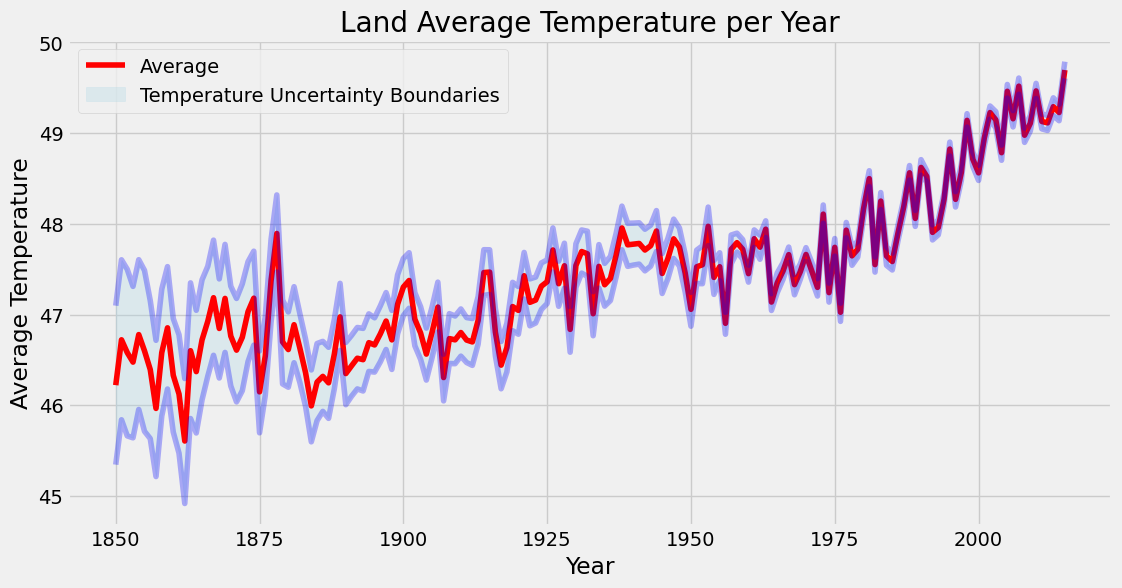

In [83]:
def plot_average_temp(df,col1,col2,label):
  cols = [col1,col2]
  temp_df = df[cols]
  average_per_year = temp_df.groupby(temp_df.index)[cols].mean()
  average_per_year['lower temp'] = average_per_year[col1] - average_per_year[col2]
  average_per_year['upper temp'] = average_per_year[col1] + average_per_year[col2]

  plt.figure(figsize=(12,6))
  plt.plot(average_per_year.index, average_per_year[col1], color='red', label='Average')
  plt.plot(average_per_year.index, average_per_year['upper temp'], color='blue', alpha=0.3)
  plt.plot(average_per_year.index, average_per_year['lower temp'], color='blue', alpha=0.3)
  plt.fill_between(average_per_year.index, average_per_year['upper temp'], average_per_year['lower temp'], color='lightblue', alpha=0.3, label='Temperature Uncertainty Boundaries')
  plt.xlabel('Year')
  plt.ylabel('Average Temperature')
  plt.title(label)
  plt.legend(loc='best')

# Land Average Temperature
plot_average_temp(temp_df_cleaned,'LandAverageTemperature','LandAverageTemperatureUncertainty','Land Average Temperature per Year')

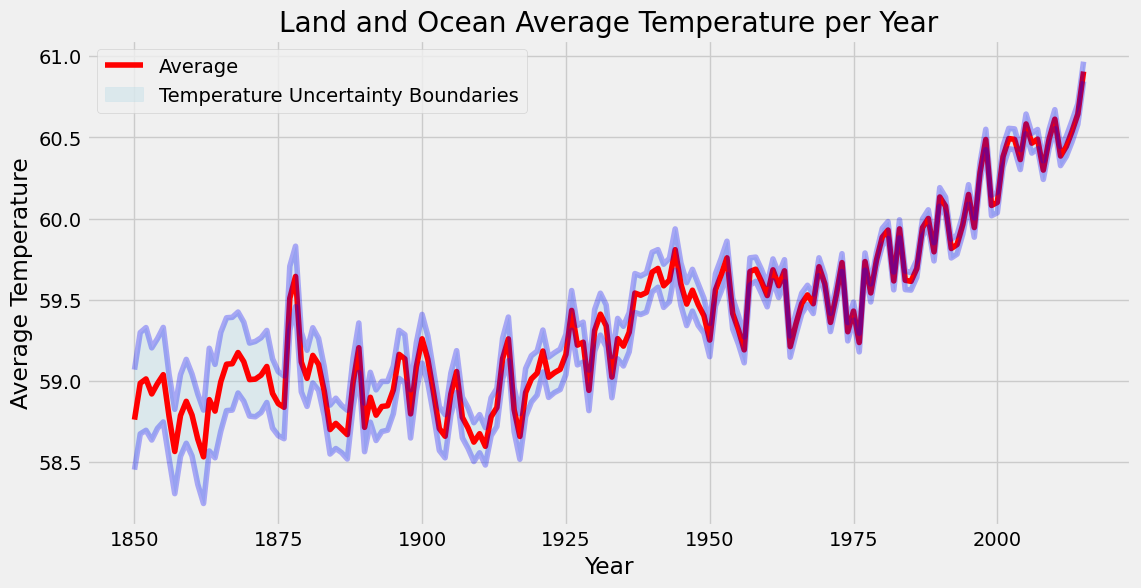

In [84]:
# Land and Ocean Average Temperature
plot_average_temp(temp_df_cleaned,'LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty','Land and Ocean Average Temperature per Year')

C:\Users\user\AppData\Local\Temp\ipykernel_5836\1395830787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_cleaned['YearInterval'] = pd.cut(temp_df_cleaned.index, bins=year_intervals + [2020], right=False, labels=year_intervals)


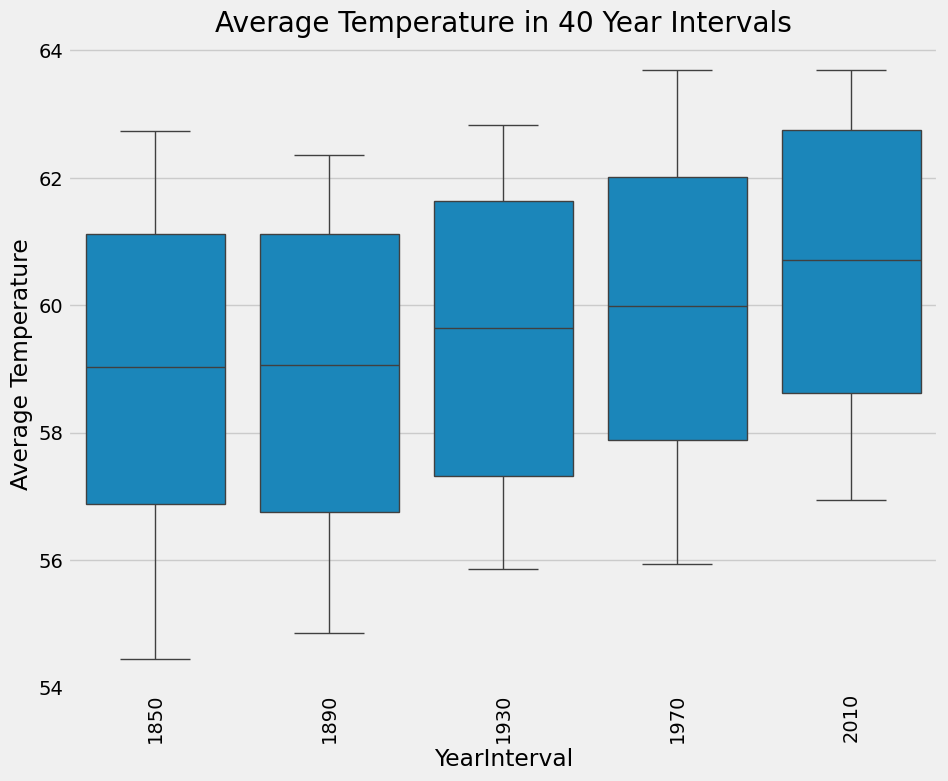

In [85]:
year_intervals = [1850, 1890, 1930, 1970, 2010]
temp_df_every_40_years = temp_df_cleaned[temp_df_cleaned.index.isin(year_intervals)]

temp_df_cleaned['YearInterval'] = pd.cut(temp_df_cleaned.index, bins=year_intervals + [2020], right=False, labels=year_intervals)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=temp_df_cleaned, x='YearInterval', y='LandAndOceanAverageTemperature', ax=ax)
ax.set(ylabel='Average Temperature', title="Average Temperature in 40 Year Intervals")
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

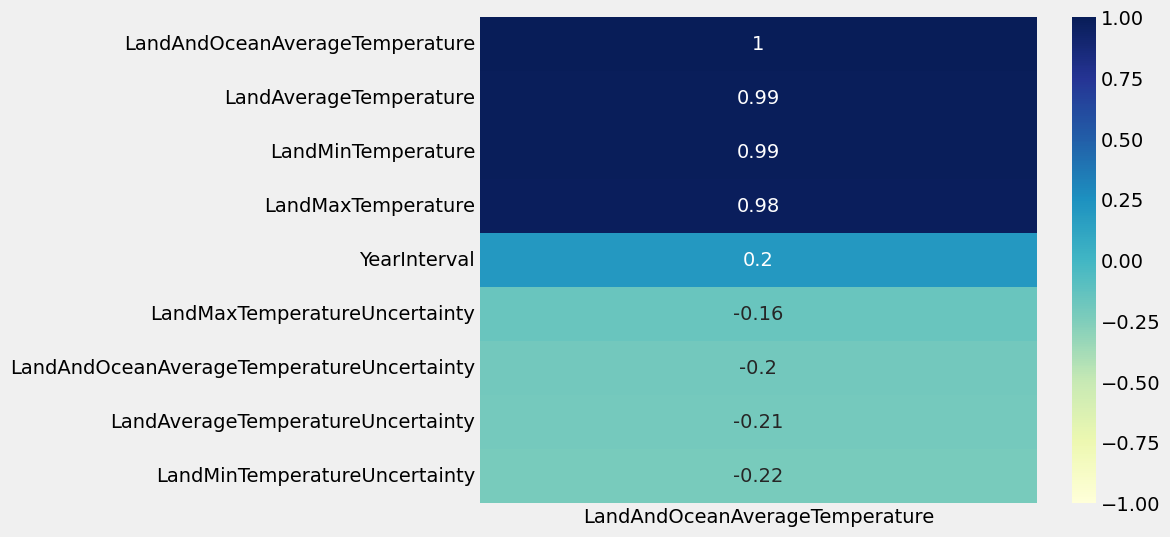

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
corr_matrix = np.abs(temp_df_cleaned.corr())
sns.heatmap(temp_df_cleaned.corr()[['LandAndOceanAverageTemperature']].sort_values('LandAndOceanAverageTemperature').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

In [87]:
def reduce_df(df):
  # Create a copy of the original dataframe
  df = df.copy()

  # Drop LandMaxTemperatureUncertainty, LandAndOceanAverageTemperatureUncertainty,
  # LandMinTemperatureUncertainty and LandMinTemperatureUncertainty
  cols_to_drop = ['LandMaxTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty',
                'LandAverageTemperatureUncertainty','LandMinTemperatureUncertainty']
  df = df.drop(cols_to_drop,axis=1)
  return df

reduced_temperature_df = reduce_df(temp_df_cleaned)

In [88]:
# Features, X
X = reduced_temperature_df.drop('LandAndOceanAverageTemperature',axis=1)
# Target, Y
Y = reduced_temperature_df['LandAndOceanAverageTemperature']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=40)
print("Size of X_train: ", X_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (1494, 4)
Size of X_test:  (498, 4)
Size of y_train:  (1494,)
Size of y_test:  (498,)


In [90]:
y_pred = [y_train.mean()] * len(y_train)

# MAE
print('Base MAE (in degrees):', round(mean_absolute_error(y_train,y_pred),2))

Base MAE (in degrees): 2.03


In [91]:
# Capture k-fold output in a dataframe for comparisons
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])
kfold_mae_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

In [92]:
# Returns a dictionary of statistics to compare model variance provided that
# five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, scoring="explained_variance",cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print("Explained Variance:", ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [93]:
# Returns a dictonary of statistics to compare model absolute error provided that
# five folds are defined.
def kfold_xval_mae(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    # Minimizing MAE is equivalent to maximizing negative-MAE
    mae_val_array = cross_val_score(model, train_data, target_data, scoring="neg_mean_absolute_error", cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': mae_val_array[0],
                    'Fold_2': mae_val_array[1],
                    'Fold_3': mae_val_array[2],
                    'Fold_4': mae_val_array[3],
                    'Fold_5': mae_val_array[4],
                   }
        print("Negative Mean Absolute Error:", ret_dict)
        return(ret_dict)
    else:
        print(mae_val_array)

In [94]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

    # Make predictions
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    fig, ax = plt.subplots(figsize=(8, 6))
    tips = sns.load_dataset("tips")
    ax = sns.regplot(data=tips,x=y_test,y=y_preds_test,scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "red"})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

    print("------------------------- Test set statistics -------------------------")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [95]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'LinearRegression()', 'Fold_1': np.float64(0.9849121210979411), 'Fold_2': np.float64(0.9877588035889393), 'Fold_3': np.float64(0.9882448466720236), 'Fold_4': np.float64(0.987729630865311), 'Fold_5': np.float64(0.9865851812995844)}


C:\Users\user\AppData\Local\Temp\ipykernel_5836\794317056.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])


In [96]:
mae_results = kfold_xval_mae(linear,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'LinearRegression()', 'Fold_1': np.float64(-0.2242212229773995), 'Fold_2': np.float64(-0.19756069898350825), 'Fold_3': np.float64(-0.20217186343432186), 'Fold_4': np.float64(-0.21249341992482818), 'Fold_5': np.float64(-0.209466882695857)}


C:\Users\user\AppData\Local\Temp\ipykernel_5836\1352722626.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])


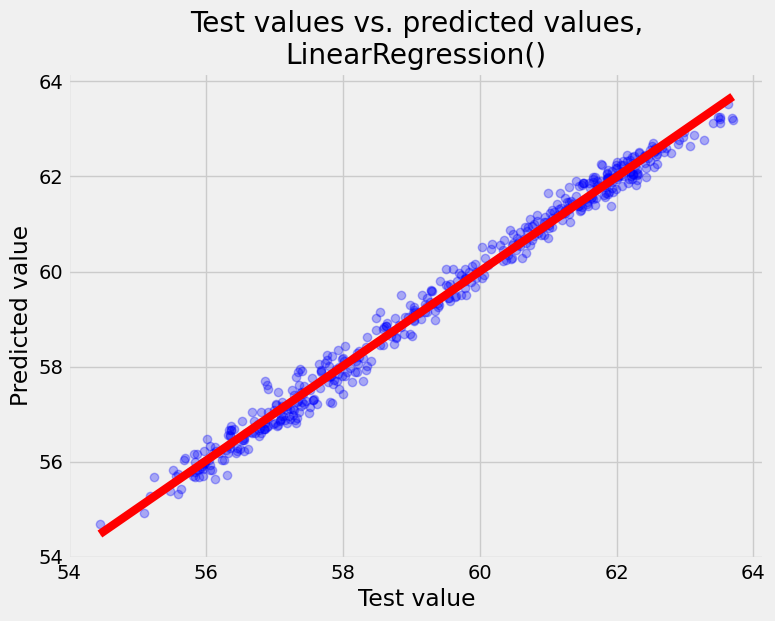

------------------------- Test set statistics -------------------------
R-squared of the model on the test set is: 0.9888167928271347
Mean absolute error of the prediction is: 0.19400321323667946
Mean squared error of the prediction is: 0.058262891544145684
Root mean squared error of the prediction is: 0.24137707336063566
Mean absolute percentage error of the prediction is: 0.327798773143612


In [97]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

<Axes: title={'center': 'Elbow Curve from RMSE'}, xlabel='k', ylabel='RMSE'>

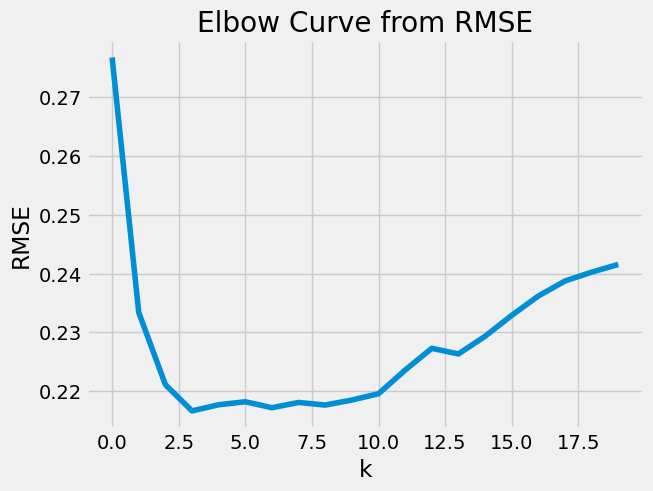

In [98]:
# Find the RMSE to plot an Elbow Curve
rmse_val = [] # Store RMSE values for different k
for k in range(20):
    k = k+1
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  # Fit the model
    pred=model.predict(X_test) # Make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) # Calculate RMSE
    rmse_val.append(error) # Store RMSE values

figsize=(8, 6)
curve = pd.DataFrame(rmse_val) # Elbow curve
curve.plot(title="Elbow Curve from RMSE", xlabel="k", ylabel="RMSE", legend=None)

In [99]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 8) # By the Elbow curve above, we set k = 8
cv_results = kfold_xval(knn_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'KNeighborsRegressor(n_neighbors=8)', 'Fold_1': np.float64(0.9884293805509266), 'Fold_2': np.float64(0.989896486525401), 'Fold_3': np.float64(0.989162799648554), 'Fold_4': np.float64(0.9909852078584297), 'Fold_5': np.float64(0.9886370372431008)}


In [100]:
mae_results = kfold_xval_mae(knn_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'KNeighborsRegressor(n_neighbors=8)', 'Fold_1': np.float64(-0.19892408026755837), 'Fold_2': np.float64(-0.17533369565217402), 'Fold_3': np.float64(-0.17727892976588602), 'Fold_4': np.float64(-0.17300769230769228), 'Fold_5': np.float64(-0.18353959731543634)}


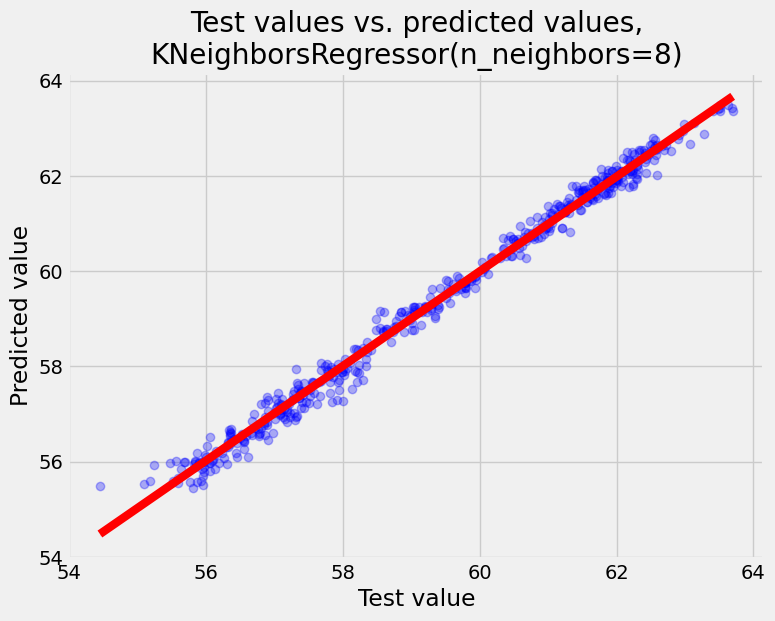

------------------------- Test set statistics -------------------------
R-squared of the model on the test set is: 0.9908702457215166
Mean absolute error of the prediction is: 0.16851054216867448
Mean squared error of the prediction is: 0.047564699028614474
Root mean squared error of the prediction is: 0.21809332641925216
Mean absolute percentage error of the prediction is: 0.28572584940586077


In [101]:
comp_train_test(knn_model,X_train,y_train,X_test,y_test)

In [102]:
rf_model = ensemble.RandomForestRegressor(n_estimators=10, n_jobs=-1)
cv_results = kfold_xval(rf_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'RandomForestRegressor(n_estimators=10, n_jobs=-1)', 'Fold_1': np.float64(0.9875745402234846), 'Fold_2': np.float64(0.9905121618105025), 'Fold_3': np.float64(0.9892973395459703), 'Fold_4': np.float64(0.98870935008746), 'Fold_5': np.float64(0.9886628718148044)}


In [103]:
mae_results = kfold_xval_mae(rf_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'RandomForestRegressor(n_estimators=10, n_jobs=-1)', 'Fold_1': np.float64(-0.19687605351170565), 'Fold_2': np.float64(-0.1735699665551843), 'Fold_3': np.float64(-0.18607966555184008), 'Fold_4': np.float64(-0.17960989966555208), 'Fold_5': np.float64(-0.18469932885906062)}


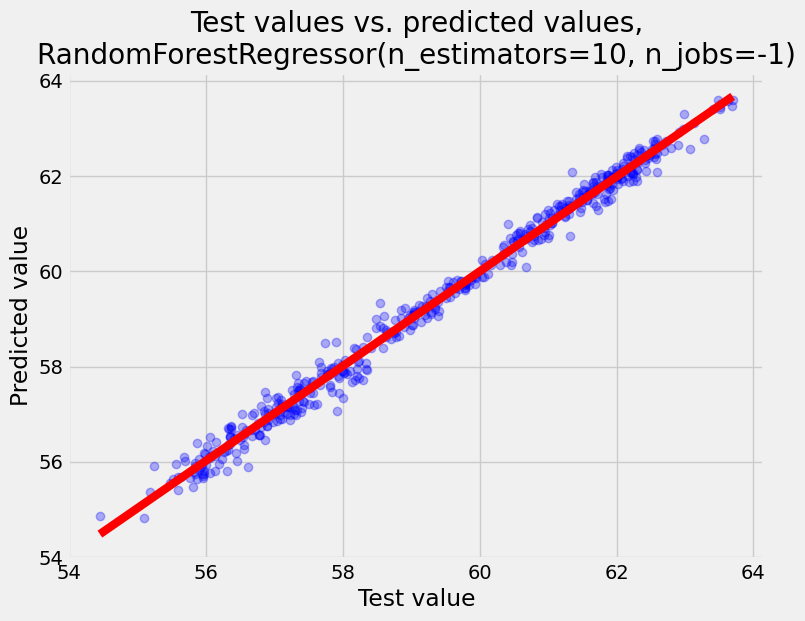

------------------------- Test set statistics -------------------------
R-squared of the model on the test set is: 0.990363065402234
Mean absolute error of the prediction is: 0.1730548192771092
Mean squared error of the prediction is: 0.050207035120482246
Root mean squared error of the prediction is: 0.22406926411376069
Mean absolute percentage error of the prediction is: 0.29342218793759384


In [104]:
comp_train_test(rf_model,X_train,y_train,X_test,y_test)

In [105]:
svm_model = SVR(kernel = 'rbf')
cv_results = kfold_xval(svm_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'SVR()', 'Fold_1': np.float64(0.13630642638534396), 'Fold_2': np.float64(0.13068694750431298), 'Fold_3': np.float64(0.13925534672879503), 'Fold_4': np.float64(0.1468342578636036), 'Fold_5': np.float64(0.1467376552838442)}


In [106]:
mae_results = kfold_xval_mae(svm_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'SVR()', 'Fold_1': np.float64(-1.9212176427989238), 'Fold_2': np.float64(-1.903008130280293), 'Fold_3': np.float64(-1.909526614354114), 'Fold_4': np.float64(-1.927383020137867), 'Fold_5': np.float64(-1.7935124185358065)}


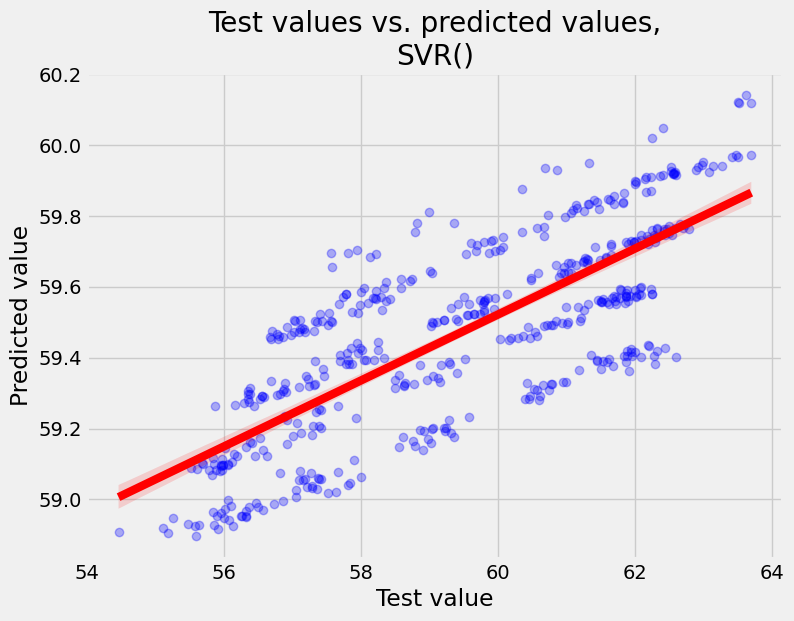

------------------------- Test set statistics -------------------------
R-squared of the model on the test set is: 0.17069174679991772
Mean absolute error of the prediction is: 1.8517642139158659
Mean squared error of the prediction is: 4.3205760267143445
Root mean squared error of the prediction is: 2.078599534954808
Mean absolute percentage error of the prediction is: 3.129661860617297


In [107]:
comp_train_test(svm_model,X_train,y_train,X_test,y_test)

In [108]:
# Search for optimal n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': range(50,500,50),
          'max_depth': [2,3,4]}
gb_model = ensemble.GradientBoostingRegressor(random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'max_depth': 4, 'n_estimators': 150}, np.float64(0.9900577207630589))

In [109]:
# Search for optimal learning_rate and loss
params = {'learning_rate': [x/10 for x in range(1,11,1)],
          'loss': ['squared_error','absolute_error','huber']}
gb_model = ensemble.GradientBoostingRegressor(max_depth=4,random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'learning_rate': 0.1, 'loss': 'huber'}, np.float64(0.9900285259442558))

In [110]:
# Search for optimal subsample and min_samples_split
params = {'subsample': [x/20 for x in range(10,20,1)],
          'min_samples_split': [2**x for x in range(1,9)]}
gb_model = ensemble.GradientBoostingRegressor(max_depth=4,random_state=99)
gscv = GridSearchCV(gb_model,params,cv=5)
gscv.fit(X_train,y_train)
gscv.best_params_, gscv.best_score_

({'min_samples_split': 2, 'subsample': 0.95}, np.float64(0.9902107583105171))

In [111]:
# These are reasonably good parameters.
params = {'loss': 'squared_error',
          'random_state': 99,
          'max_depth': 4,
          'n_estimators': 100,
          'learning_rate': 0.1,
          'subsample': 0.75,
          'min_samples_split': 2,
         }
gb_model = ensemble.GradientBoostingRegressor(**params)
cv_results = kfold_xval(gb_model,X_train,y_train,num_folds=5)
kfold_df = pd.concat([kfold_df, pd.DataFrame.from_records([cv_results])])

Cross-validation using 5 folds
Explained Variance: {'Model': 'GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)', 'Fold_1': np.float64(0.9882394597490791), 'Fold_2': np.float64(0.9914400406107374), 'Fold_3': np.float64(0.9905860239968652), 'Fold_4': np.float64(0.9903897067054185), 'Fold_5': np.float64(0.990075765654662)}


In [112]:
mae_results = kfold_xval_mae(gb_model,X_train,y_train,num_folds=5)
kfold_mae_df = pd.concat([kfold_mae_df, pd.DataFrame.from_records([mae_results])])

Cross-validation using 5 folds
Negative Mean Absolute Error: {'Model': 'GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)', 'Fold_1': np.float64(-0.19593918456868223), 'Fold_2': np.float64(-0.1598011613788764), 'Fold_3': np.float64(-0.17055064618564025), 'Fold_4': np.float64(-0.1785286319972336), 'Fold_5': np.float64(-0.17591924444799462)}


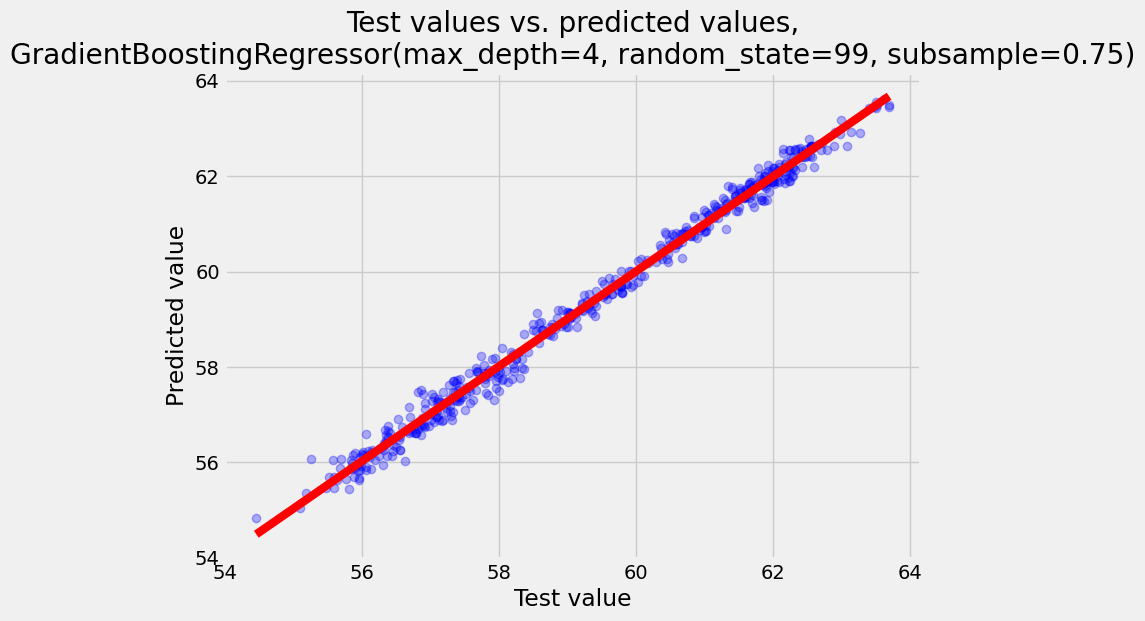

------------------------- Test set statistics -------------------------
R-squared of the model on the test set is: 0.9914040931150868
Mean absolute error of the prediction is: 0.16647842373317923
Mean squared error of the prediction is: 0.04478343133751992
Root mean squared error of the prediction is: 0.2116209614795281
Mean absolute percentage error of the prediction is: 0.2820559604187468


In [113]:
comp_train_test(gb_model,X_train,y_train,X_test,y_test)

In [114]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
fold_cols = ['Fold_1','Fold_2','Fold_3','Fold_4','Fold_5']
kfold_df['avg_explained_variance'] = kfold_df[fold_cols].mean(axis=1)
kfold_df.sort_values(['avg_explained_variance'],ascending=False)
kfold_df.style.hide(axis="index")

Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_explained_variance
LinearRegression(),0.984912,0.987759,0.988245,0.987730,0.986585,0.987046
KNeighborsRegressor(n_neighbors=8),0.988429,0.989896,0.989163,0.990985,0.988637,0.989422
"RandomForestRegressor(n_estimators=10, n_jobs=-1)",0.987575,0.990512,0.989297,0.988709,0.988663,0.988951
SVR(),0.136306,0.130687,0.139255,0.146834,0.146738,0.139964
"GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)",0.988239,0.991440,0.990586,0.990390,0.990076,0.990146


In [115]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
kfold_mae_df['avg_neg_means_abs_error'] = kfold_mae_df[fold_cols].mean(axis=1)
kfold_mae_df.sort_values(['avg_neg_means_abs_error'],ascending=False)
kfold_mae_df.style.hide(axis="index")

Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_neg_means_abs_error
LinearRegression(),-0.224221,-0.197561,-0.202172,-0.212493,-0.209467,-0.209183
KNeighborsRegressor(n_neighbors=8),-0.198924,-0.175334,-0.177279,-0.173008,-0.183540,-0.181617
"RandomForestRegressor(n_estimators=10, n_jobs=-1)",-0.196876,-0.173570,-0.186080,-0.179610,-0.184699,-0.184167
SVR(),-1.921218,-1.903008,-1.909527,-1.927383,-1.793512,-1.890930
"GradientBoostingRegressor(max_depth=4, random_state=99, subsample=0.75)",-0.195939,-0.159801,-0.170551,-0.178529,-0.175919,-0.176148


In [116]:
# MAE
print('KNN Regressor Train MAE (in degrees):', round(mean_absolute_error(y_train,knn_model.predict(X_train)),2))
print('KNN Regressor Test MAE (in degrees):', round(mean_absolute_error(y_test,knn_model.predict(X_test)),2))

KNN Regressor Train MAE (in degrees): 0.15
KNN Regressor Test MAE (in degrees): 0.17


In [117]:
mape = mean_absolute_percentage_error(y_test, knn_model.predict(X_test)) * 100
accuracy = 100 - mape
print("Accuracy of Gradient Boosting Model:", round(accuracy,2), "%.")

Accuracy of Gradient Boosting Model: 99.71 %.


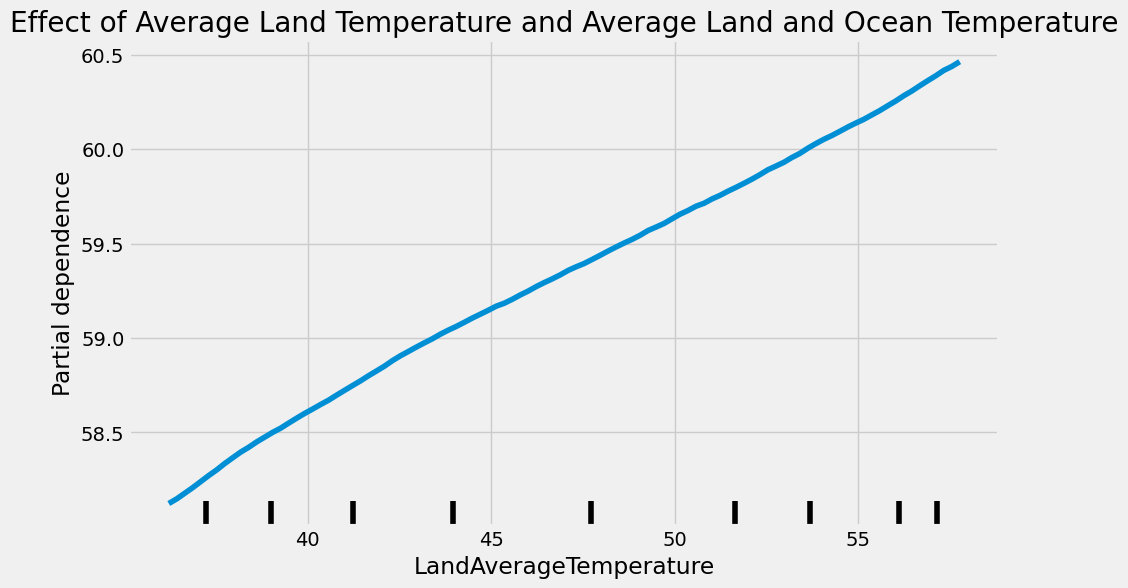

In [118]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Effect of Average Land Temperature and Average Land and Ocean Temperature")
# The feature that we want to compare against our model to see the net effect on the model prediction (our target)
feature = ['LandAverageTemperature' ]
gb_disp = PartialDependenceDisplay.from_estimator(knn_model, X_test, feature, ax=ax)

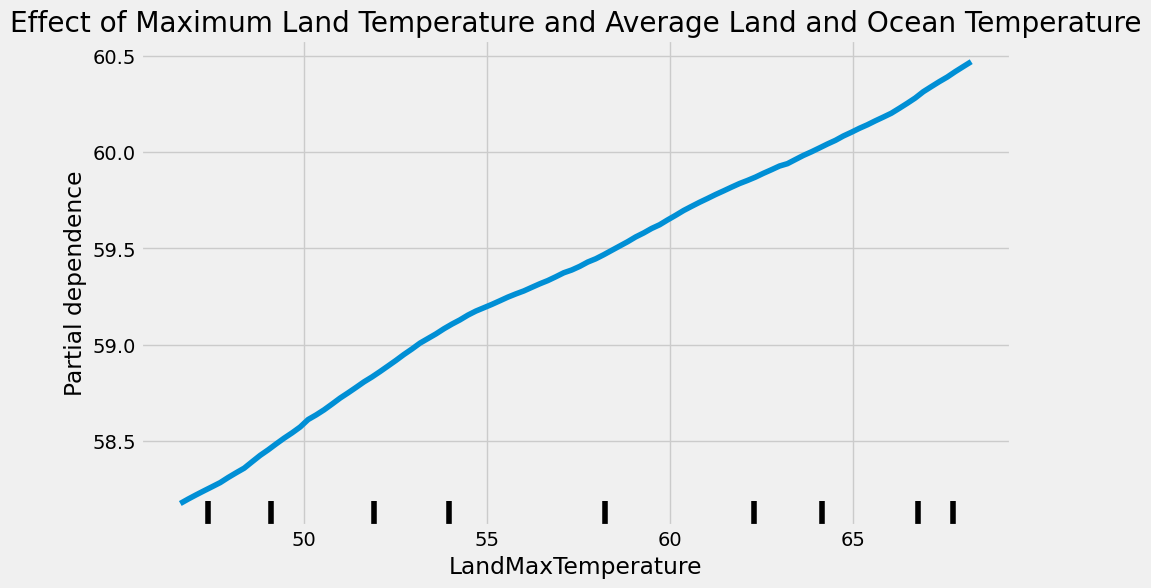

In [119]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Effect of Maximum Land Temperature and Average Land and Ocean Temperature")
feature = ['LandMaxTemperature']
gb_disp = PartialDependenceDisplay.from_estimator(knn_model, X_test, feature, ax=ax)

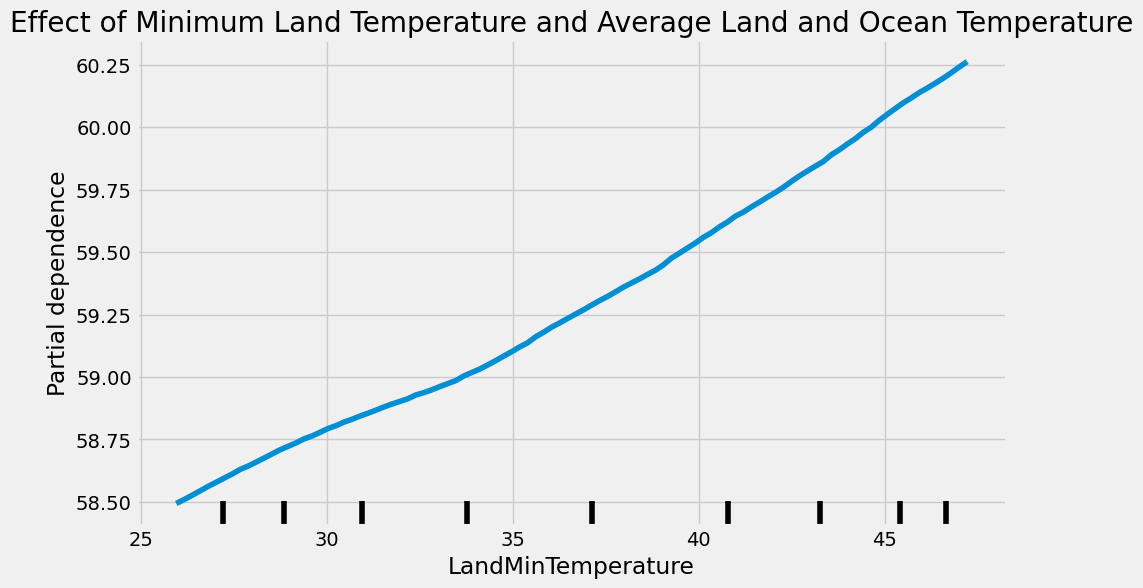

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Effect of Minimum Land Temperature and Average Land and Ocean Temperature")
# The feature that we want to compare against our model to see the net effect on the model prediction (our target)
feature = ['LandMinTemperature']
gb_disp = PartialDependenceDisplay.from_estimator(knn_model, X_test, feature, ax=ax)

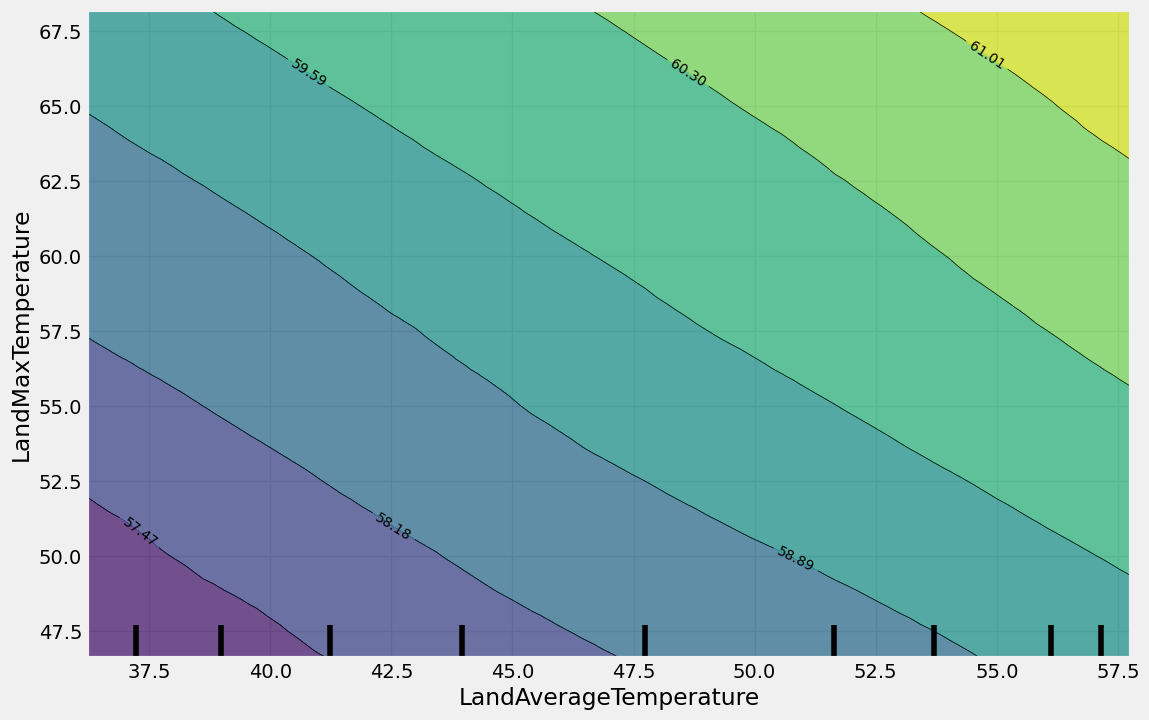

In [121]:
features = [('LandAverageTemperature','LandMaxTemperature')];
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(knn_model, X_test, features,ax=ax)
plt.show()

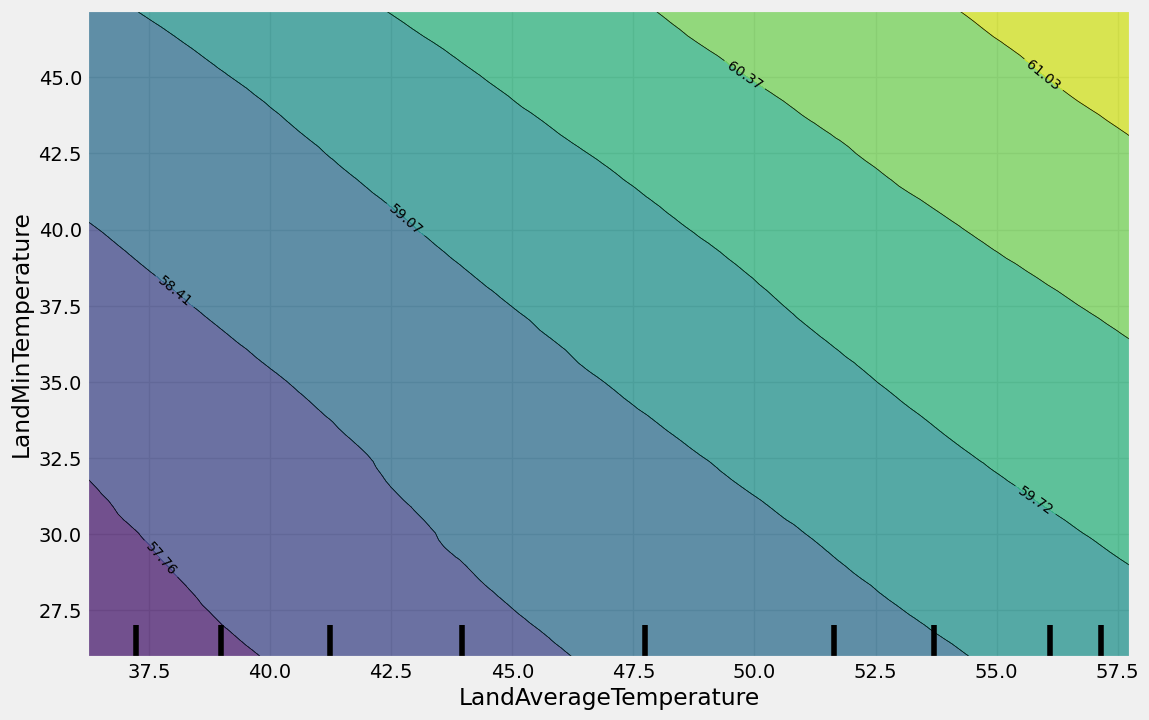

In [122]:
features = [('LandAverageTemperature','LandMinTemperature')];
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(knn_model, X_test, features,ax=ax)
plt.show()